Using device: cuda
Downloaded 8760 candles...
Downloaded 8760 candles
Data shape: (8760, 7)
Data with features: (8561, 70)
Validating data...
Train data: 6848 samples
Test data: 1713 samples

=== Training XGBoost Direction Predictor ===
XGBoost train samples: 5456
XGBoost validation samples: 1364
Training XGBoost ensemble...
Training model 1/5
Training model 2/5
Training model 3/5
Training model 4/5
Training model 5/5
XGBoost validation accuracy: 57.26%

=== Initializing PPO Agent ===
State dimension: 57
Action dimension: 4
Initial state shape: (57,)
Sample state values: [0.00071707 0.00071681 0.00553341 0.00427984 0.00123669]...

Testing agent initialization...
Test action: 1
Valid actions at start: [0, 1, 2]

=== Training PPO Agent ===
Episode 0 - Initial state shape: (57,)
Episode 0 - Initial balance: 10000
Episode 0 completed - Steps: 6163
Memory sizes - states: 6164, rewards: 6163, values: 6164
Episode 0 (Phase 1: Learning Basic Patterns)
  Profit: -6.30% | Avg: -6.30% | Best: -6.

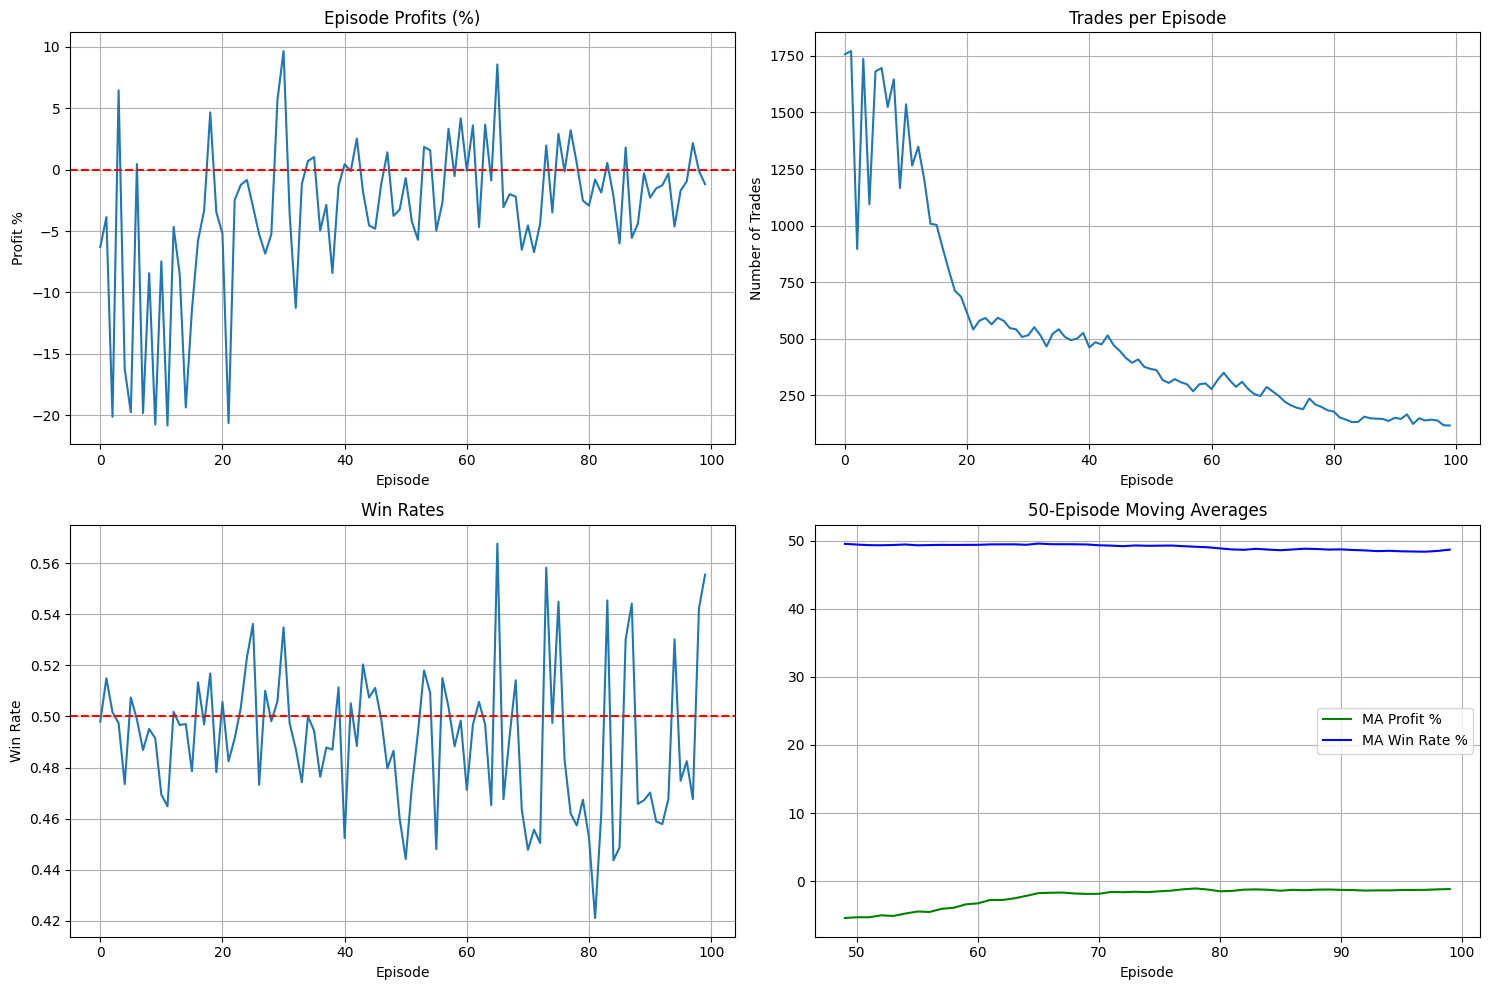


[Trade #1] LONG Entry: $78757.00 Exit: $79502.07 P&L: $4.99 (0.95%) Leverage: 1x

[Trade #2] SHORT Entry: $82804.87 Exit: $83208.04 P&L: $-14.03 (-0.49%) Leverage: 3x

[Trade #3] SHORT Entry: $85517.29 Exit: $85276.90 P&L: $10.39 (0.28%) Leverage: 5x

[Trade #4] SHORT Entry: $84093.22 Exit: $83849.66 P&L: $6.47 (0.29%) Leverage: 3x

[Trade #5] SHORT Entry: $85128.76 Exit: $84341.99 P&L: $6.53 (0.92%) Leverage: 1x

[Trade #6] LONG Entry: $84861.82 Exit: $84500.01 P&L: $-2.56 (-0.43%) Leverage: 1x

[Trade #7] SHORT Entry: $85589.23 Exit: $84918.14 P&L: $5.51 (0.78%) Leverage: 1x

[Trade #8] LONG Entry: $85048.55 Exit: $83281.21 P&L: $-10.99 (-2.08%) Leverage: 1x

[Trade #9] SHORT Entry: $84272.86 Exit: $84669.98 P&L: $-1.49 (-0.47%) Leverage: 1x

[Trade #10] LONG Entry: $84475.14 Exit: $84087.08 P&L: $-2.21 (-0.46%) Leverage: 1x

[Trade #11] SHORT Entry: $93620.89 Exit: $93497.88 P&L: $1.24 (0.13%) Leverage: 5x

[Trade #12] SHORT Entry: $93816.42 Exit: $94417.29 P&L: $-3.85 (-0.64%) Lev

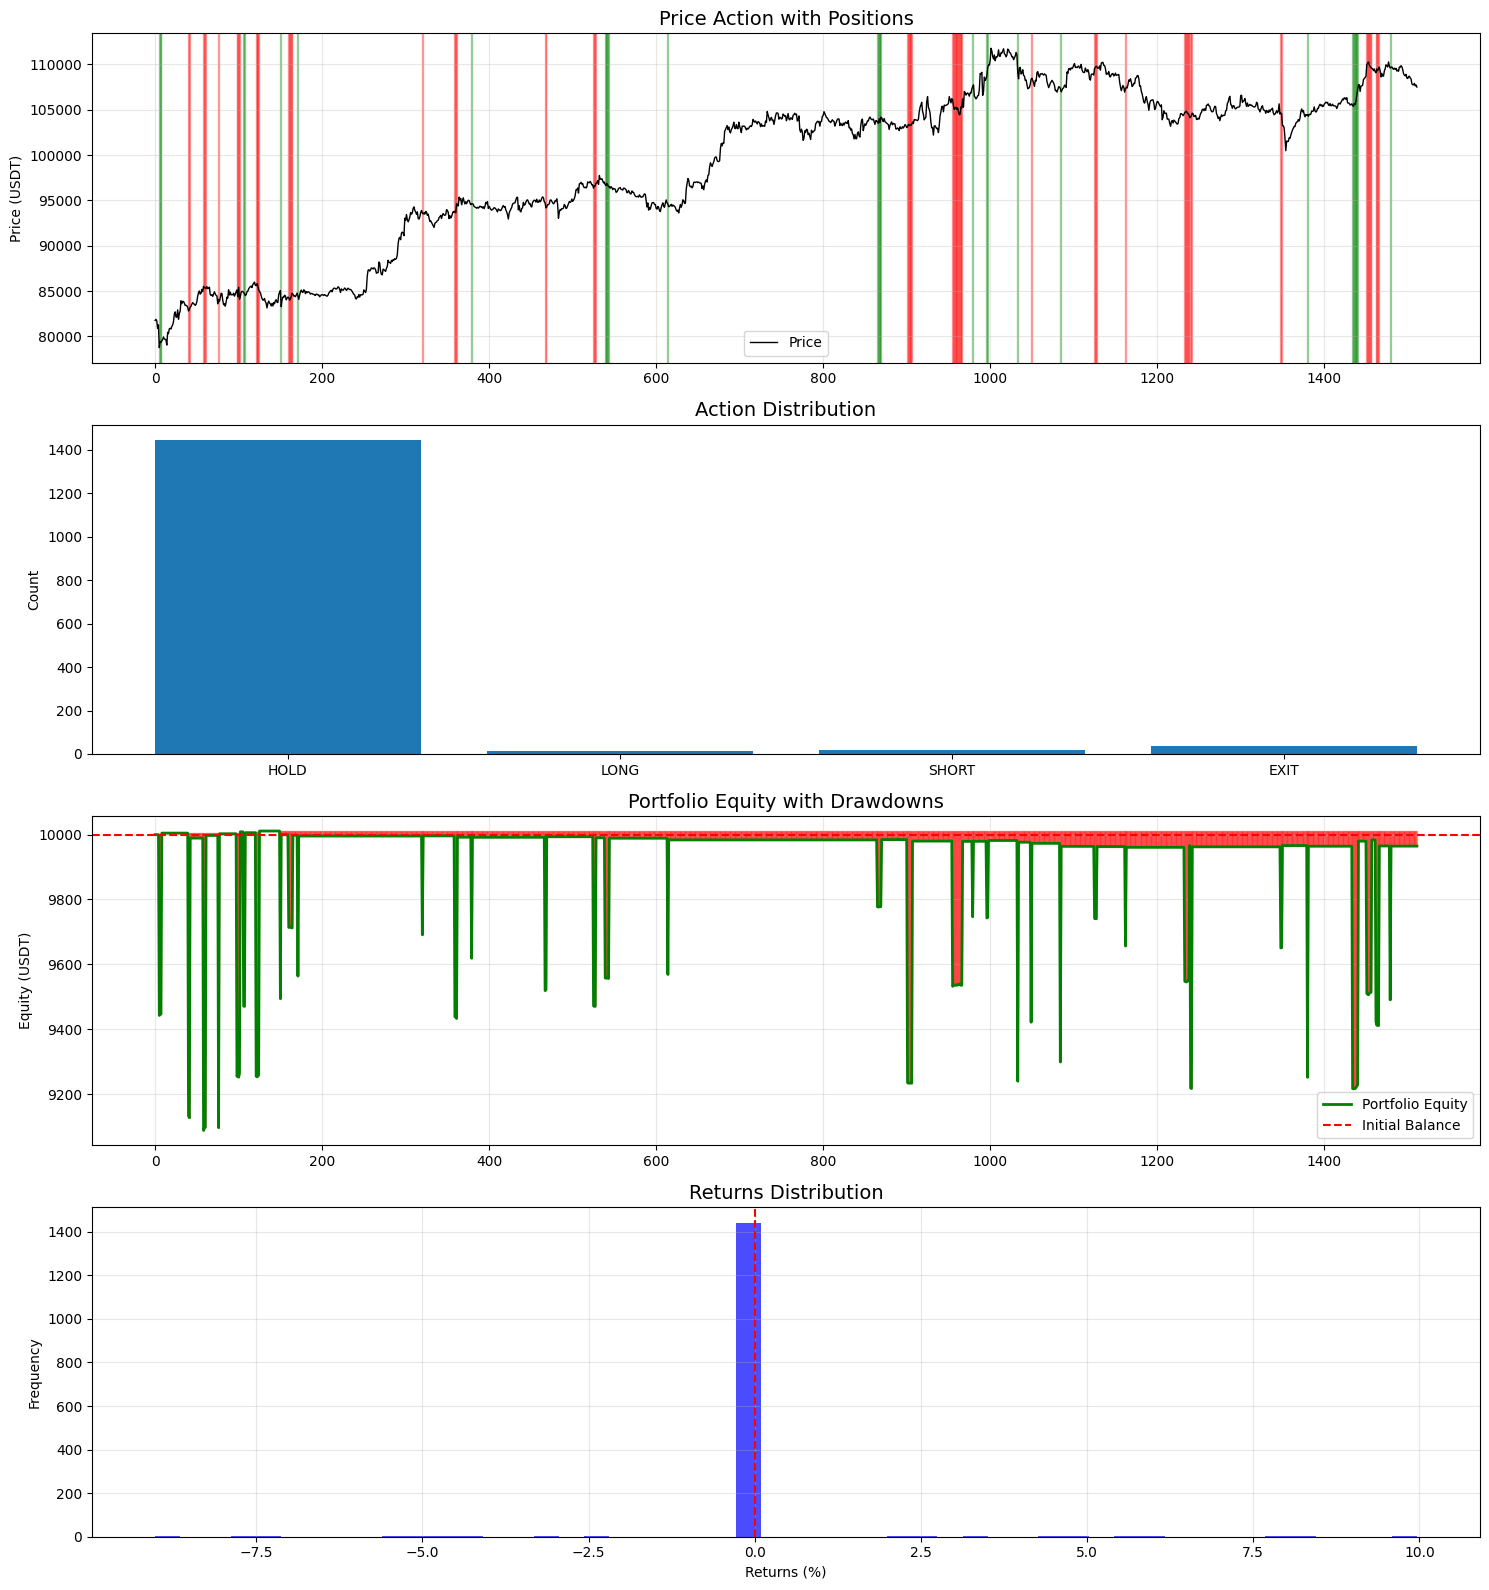

In [7]:
# %% [markdown]
# # Advanced Cryptocurrency Futures Trading Bot: Ensemble PPO + XGBoost (Debugged Version)
# 
# Fixed issues:
# - Unrealistic profit calculations
# - Position plotting errors
# - Added detailed logging for backtesting

# %% [markdown]
# ## 1. Import Libraries and Setup

# %%
import ccxt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import json
from typing import Dict, List, Tuple, Optional
import requests
from scipy import stats
import talib
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# %% [markdown]
# ## 2. Data Collection with Advanced Features

# %%
def download_crypto_data(symbol='BTC/USDT', timeframe='1h', days=365):
    """Download crypto data with volume profile"""
    exchange = ccxt.binance({
        'rateLimit': 1200,
        'enableRateLimit': True,
    })
    
    end_time = exchange.milliseconds()
    start_time = end_time - (days * 24 * 60 * 60 * 1000)
    
    print(f"Downloading {symbol} {timeframe} data...")
    all_ohlcv = []
    
    while start_time < end_time:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, start_time, 1500)
            if not ohlcv:
                break
            all_ohlcv.extend(ohlcv)
            start_time = ohlcv[-1][0] + 1
            print(f"Downloaded {len(all_ohlcv)} candles...", end='\r')
        except Exception as e:
            print(f"Error: {e}")
            break
    
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop_duplicates(subset=['timestamp']).reset_index(drop=True)
    
    print(f"\nDownloaded {len(df)} candles")
    return df

# Fetch funding rate data (mock function - in production use real API)
def get_funding_rate(symbol='BTCUSDT'):
    """Get current funding rate - critical for futures trading"""
    # In production, use: exchange.fetch_funding_rate(symbol)
    # Mock implementation
    return np.random.uniform(-0.001, 0.001)  # -0.1% to 0.1%

# Download main data
data = download_crypto_data(days=365)
print(f"Data shape: {data.shape}")

# %% [markdown]
# ## 3. Advanced Feature Engineering

# %%
def calculate_advanced_features(df):
    """Calculate all features including crypto-specific ones"""
    df = df.copy()
    
    # === Basic Price Features ===
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['high_low_ratio'] = (df['high'] - df['low']) / df['close']
    df['close_to_high'] = (df['high'] - df['close']) / df['high']
    df['close_to_low'] = (df['close'] - df['low']) / df['low'].replace(0, 1e-8)  # Avoid division by zero
    
    # === Volatility Features ===
    df['volatility_20'] = df['returns'].rolling(20).std()
    df['volatility_50'] = df['returns'].rolling(50).std()
    df['atr'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['natr'] = talib.NATR(df['high'], df['low'], df['close'], timeperiod=14)
    
    # === Moving Averages & Trends ===
    for period in [7, 14, 20, 50, 100, 200]:
        df[f'sma_{period}'] = talib.SMA(df['close'], timeperiod=period)
        df[f'ema_{period}'] = talib.EMA(df['close'], timeperiod=period)
    
    # Price position relative to MAs
    df['price_to_sma20'] = (df['close'] - df['sma_20']) / df['sma_20']
    df['price_to_sma50'] = (df['close'] - df['sma_50']) / df['sma_50']
    
    # MA Cross signals
    df['ma_cross_bullish'] = ((df['sma_20'] > df['sma_50']) & 
                              (df['sma_20'].shift(1) <= df['sma_50'].shift(1))).astype(int)
    df['ma_cross_bearish'] = ((df['sma_20'] < df['sma_50']) & 
                              (df['sma_20'].shift(1) >= df['sma_50'].shift(1))).astype(int)
    
    # === FIXED: Add trend indicators ===
    # Simple trend based on 20-period price change
    df['trend_20'] = np.where(df['close'] > df['close'].shift(20), 1, -1)
    
    # === Momentum Indicators ===
    df['rsi'] = talib.RSI(df['close'], timeperiod=14)
    df['rsi_ma'] = df['rsi'].rolling(10).mean()
    
    # Stochastic RSI
    df['stochrsi_k'], df['stochrsi_d'] = talib.STOCHRSI(df['close'], 
                                                         timeperiod=14, 
                                                         fastk_period=3, 
                                                         fastd_period=3)
    
    # MACD
    df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(df['close'], 
                                                                 fastperiod=12, 
                                                                 slowperiod=26, 
                                                                 signalperiod=9)
    
    # === Bollinger Bands ===
    df['bb_upper'], df['bb_middle'], df['bb_lower'] = talib.BBANDS(df['close'], 
                                                                    timeperiod=20, 
                                                                    nbdevup=2, 
                                                                    nbdevdn=2)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    
    # === Volume Analysis ===
    df['volume_sma'] = df['volume'].rolling(20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma']
    df['obv'] = talib.OBV(df['close'], df['volume'])
    df['obv_ma'] = df['obv'].rolling(20).mean()
    
    # Volume-Weighted Average Price
    df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()
    df['price_to_vwap'] = (df['close'] - df['vwap']) / df['vwap']
    
    # === Market Structure ===
    # Support and Resistance levels
    df['resistance'] = df['high'].rolling(20).max()
    df['support'] = df['low'].rolling(20).min()
    df['price_to_resistance'] = (df['close'] - df['resistance']) / df['resistance']
    df['price_to_support'] = (df['close'] - df['support']) / df['support']
    
    # Higher Highs and Lower Lows
    df['higher_high'] = (df['high'] > df['high'].rolling(20).max().shift(1)).astype(int)
    df['lower_low'] = (df['low'] < df['low'].rolling(20).min().shift(1)).astype(int)
    
    # === Crypto-Specific Features ===
    # Funding Rate simulation (in production, use real data)
    df['funding_rate'] = np.random.uniform(-0.001, 0.001, len(df))
    df['funding_rate_ma'] = df['funding_rate'].rolling(8).mean()  # 8-hour average
    
    # Extreme funding rate indicator
    df['extreme_funding'] = (np.abs(df['funding_rate']) > 0.001).astype(int)
    
    # Market fear/greed proxy (based on volatility and volume)
    df['fear_greed'] = (df['volatility_20'] / df['volatility_20'].rolling(100).mean()) * \
                       (df['volume_ratio'] / df['volume_ratio'].rolling(100).mean())
    
    # === Multi-Timeframe Features ===
    # Aggregate features from larger timeframes
    df['returns_4h'] = df['close'].pct_change(4)
    df['returns_24h'] = df['close'].pct_change(24)
    df['high_24h'] = df['high'].rolling(24).max()
    df['low_24h'] = df['low'].rolling(24).min()
    df['range_24h'] = (df['high_24h'] - df['low_24h']) / df['close']
    
    # === Market Regime Detection ===
    # Trend strength
    df['adx'] = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
    df['trend_strength'] = df['adx'] / 100
    
    # Market regime
    df['trending'] = (df['adx'] > 25).astype(int)
    df['ranging'] = (df['adx'] < 20).astype(int)
    
    # Drop NaN values
    df = df.dropna()
    
    # Replace any remaining NaN or inf values
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(0)
    
    return df

# Apply feature engineering
data = calculate_advanced_features(data)
print(f"Data with features: {data.shape}")

# Select feature columns
feature_columns = [
    # Price action
    'returns', 'log_returns', 'high_low_ratio', 'close_to_high', 'close_to_low',
    # Volatility
    'volatility_20', 'volatility_50', 'atr', 'natr',
    # Trend
    'price_to_sma20', 'price_to_sma50', 'ma_cross_bullish', 'ma_cross_bearish',
    # Momentum
    'rsi', 'rsi_ma', 'stochrsi_k', 'stochrsi_d', 'macd', 'macd_signal', 'macd_hist',
    # Bollinger Bands
    'bb_width', 'bb_position',
    # Volume
    'volume_ratio', 'price_to_vwap',
    # Market structure
    'price_to_resistance', 'price_to_support', 'higher_high', 'lower_low',
    # Crypto-specific
    'funding_rate', 'funding_rate_ma', 'extreme_funding', 'fear_greed',
    # Multi-timeframe
    'returns_4h', 'returns_24h', 'range_24h',
    # Market regime
    'adx', 'trend_strength', 'trending', 'ranging'
]

# %% [markdown]
# ## 4. XGBoost Direction Predictor

# %%
class DirectionPredictor:
    """XGBoost model for predicting price direction"""
    
    def __init__(self, lookback=24, prediction_horizon=4):
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.models = {}  # Store multiple models for ensemble
        self.scalers = {}
        self.feature_importance = None
        
    def prepare_data(self, df, feature_cols):
        """Prepare data for XGBoost"""
        X, y = [], []
        
        # Create sequences
        for i in range(self.lookback, len(df) - self.prediction_horizon):
            # Features: past lookback periods
            X.append(df[feature_cols].iloc[i-self.lookback:i].values.flatten())
            
            # Target: future price direction (1 for up, 0 for down)
            future_return = (df['close'].iloc[i + self.prediction_horizon] - 
                           df['close'].iloc[i]) / df['close'].iloc[i]
            y.append(1 if future_return > 0.001 else 0)  # 0.1% threshold
        
        return np.array(X), np.array(y)
    
    def train_ensemble(self, X_train, y_train, n_models=5):
        """Train ensemble of XGBoost models"""
        print("Training XGBoost ensemble...")
        
        for i in range(n_models):
            print(f"Training model {i+1}/{n_models}")
            
            # Different random seeds for diversity
            params = {
                'objective': 'binary:logistic',
                'max_depth': np.random.randint(3, 8),
                'learning_rate': np.random.uniform(0.01, 0.1),
                'n_estimators': np.random.randint(100, 300),
                'subsample': np.random.uniform(0.6, 0.9),
                'colsample_bytree': np.random.uniform(0.6, 0.9),
                'random_state': i * 42,
                'use_label_encoder': False,
                'eval_metric': 'logloss'
            }
            
            model = xgb.XGBClassifier(**params)
            model.fit(X_train, y_train)
            self.models[f'model_{i}'] = model
        
        # Get feature importance from first model
        self.feature_importance = self.models['model_0'].feature_importances_
        
    def predict_proba(self, X):
        """Get ensemble predictions"""
        predictions = []
        
        for model in self.models.values():
            pred = model.predict_proba(X)[:, 1]  # Probability of up movement
            predictions.append(pred)
        
        # Average predictions
        return np.mean(predictions, axis=0)
    
    def predict(self, X, threshold=0.6):
        """Get binary predictions with confidence threshold"""
        proba = self.predict_proba(X)
        
        # Only predict when confident
        predictions = np.zeros(len(proba))
        predictions[proba > threshold] = 1  # Strong bullish
        predictions[proba < (1 - threshold)] = -1  # Strong bearish
        
        return predictions

# %% [markdown]
# ## 5. PPO Implementation

# %%
class ActorCriticNetwork(nn.Module):
    """Actor-Critic network for PPO"""
    
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        
        # Shared layers
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        
        # Actor head
        self.actor_fc = nn.Linear(hidden_dim, hidden_dim // 2)
        self.actor_out = nn.Linear(hidden_dim // 2, action_dim)
        
        # Critic head
        self.critic_fc = nn.Linear(hidden_dim, hidden_dim // 2)
        self.critic_out = nn.Linear(hidden_dim // 2, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights to prevent gradient issues"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, state):
        # Check for NaN in input
        if torch.isnan(state).any():
            state = torch.nan_to_num(state, 0.0)
        
        # Shared network
        x = F.relu(self.ln1(self.fc1(state)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        
        # Actor
        actor = F.relu(self.actor_fc(x))
        action_logits = self.actor_out(actor)
        
        # Add small epsilon to prevent log(0)
        action_probs = F.softmax(action_logits, dim=-1) + 1e-8
        
        # Critic
        critic = F.relu(self.critic_fc(x))
        value = self.critic_out(critic).squeeze(-1)  # Ensure consistent shape
        
        return action_probs, value

class PPOAgent:
    """Proximal Policy Optimization agent"""
    
    def __init__(self, state_dim, action_dim, lr=1e-4):  # Reduced learning rate
        self.action_dim = action_dim
        
        # Networks
        self.network = ActorCriticNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
        # PPO parameters
        self.gamma = 0.99
        self.gae_lambda = 0.95
        self.clip_epsilon = 0.2
        self.value_coef = 0.5
        self.entropy_coef = 0.01
        self.max_grad_norm = 0.5
        
        # Memory
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
        
    def act(self, state, xgb_signal=None, valid_actions=None):
        """Select action using actor network and XGBoost signal"""
        # Validate state
        state = np.nan_to_num(state, 0.0)
        state = np.clip(state, -10, 10)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            action_probs, value = self.network(state_tensor)
        
        # Ensure valid probabilities
        action_probs = action_probs.cpu()
        
        # CRITICAL FIX: Check if valid_actions is provided
        if valid_actions is None:
            # Default: all actions are valid
            valid_actions = list(range(self.action_dim))
        
        # Mask invalid actions
        mask = torch.zeros(1, self.action_dim)
        for action in valid_actions:
            mask[0, action] = 1
        
        # Apply mask
        action_probs = action_probs * mask
        
        # Renormalize
        if action_probs.sum() > 0:
            action_probs = action_probs / action_probs.sum(dim=-1, keepdim=True)
        else:
            # Fallback: uniform over valid actions
            action_probs = mask / mask.sum()
        
        # Incorporate XGBoost signal if available
        if xgb_signal is not None and not np.isnan(xgb_signal):
            # FIXED: Check valid_actions before using 'in' operator
            if xgb_signal > 0 and 1 in valid_actions:  # Bullish signal and can LONG
                action_probs[0, 1] *= 1.2  # Slightly increase LONG probability
                if 2 in valid_actions:
                    action_probs[0, 2] *= 0.8  # Slightly decrease SHORT probability
            elif xgb_signal < 0 and 2 in valid_actions:  # Bearish signal and can SHORT
                if 1 in valid_actions:
                    action_probs[0, 1] *= 0.8  # Slightly decrease LONG probability
                action_probs[0, 2] *= 1.2  # Slightly increase SHORT probability
            
            # Renormalize
            action_probs = action_probs / action_probs.sum(dim=-1, keepdim=True)
        
        # Ensure no NaN values
        if torch.isnan(action_probs).any():
            action_probs = torch.ones(1, self.action_dim) / self.action_dim
            mask = torch.zeros(1, self.action_dim)
            for action in valid_actions:
                mask[0, action] = 1
            action_probs = mask / mask.sum()
        
        # Add small epsilon to prevent numerical issues
        action_probs = action_probs + 1e-8
        action_probs = action_probs / action_probs.sum(dim=-1, keepdim=True)
        
        dist = Categorical(action_probs)
        action = dist.sample()
        
        # Store for training - ensure value is scalar
        self.states.append(state)
        self.actions.append(action.item())
        # Handle both single value and batch value shapes
        if value.dim() == 0:
            self.values.append(value.cpu().item())
        else:
            self.values.append(value[0].cpu().item() if len(value) > 0 else 0.0)
        self.log_probs.append(dist.log_prob(action).item())
        
        return action.item()
    
    def store_reward(self, reward, done):
        """Store reward and done flag"""
        self.rewards.append(reward)
        self.dones.append(done)
    
    def compute_gae(self):
        """Compute Generalized Advantage Estimation"""
        # Ensure all lists have same length
        min_length = min(len(self.rewards), len(self.values), len(self.dones))
        
        if min_length == 0:
            return torch.FloatTensor([]).to(device), torch.FloatTensor([]).to(device)
        
        # Trim to same length
        rewards = self.rewards[:min_length]
        values = self.values[:min_length]
        dones = self.dones[:min_length]
        
        advantages = []
        advantage = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[t + 1]
            
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            advantage = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * advantage
            advantages.insert(0, advantage)
        
        advantages = torch.FloatTensor(advantages).to(device)
        returns = advantages + torch.FloatTensor(values).to(device)
        
        # Normalize advantages
        if advantages.numel() > 0:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        return advantages, returns
    
    def update(self, epochs=10):
        """Update policy using PPO"""
        # Reduced minimum batch size for debugging
        if len(self.states) < 32:  
            return
        
        # Debug info
        if len(self.states) != len(self.rewards) or len(self.states) != len(self.values):
            print(f"Warning: Data length mismatch - states: {len(self.states)}, "
                  f"rewards: {len(self.rewards)}, values: {len(self.values)}, "
                  f"actions: {len(self.actions)}, dones: {len(self.dones)}")
        
        # Compute advantages and returns
        advantages, returns = self.compute_gae()
        
        if advantages.numel() == 0:
            return
        
        # Ensure all data has same length
        min_length = min(len(self.states), len(self.actions), len(self.log_probs), 
                         advantages.shape[0], returns.shape[0])
        
        # Convert to tensors with same length
        states = torch.FloatTensor(self.states[:min_length]).to(device)
        actions = torch.LongTensor(self.actions[:min_length]).to(device)
        old_log_probs = torch.FloatTensor(self.log_probs[:min_length]).to(device)
        advantages = advantages[:min_length]
        returns = returns[:min_length]
        
        # PPO update
        for _ in range(epochs):
            # Get current policy
            action_probs, values = self.network(states)
            dist = Categorical(action_probs)
            log_probs = dist.log_prob(actions)
            entropy = dist.entropy()
            
            # Compute ratios
            ratios = torch.exp(log_probs - old_log_probs)
            
            # Clipped surrogate loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Value loss
            value_loss = F.mse_loss(values, returns)
            
            # Total loss
            loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy.mean()
            
            # Check for NaN
            if torch.isnan(loss):
                print("Warning: NaN loss detected, skipping update")
                break
            
            # Update
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.max_grad_norm)
            self.optimizer.step()
        
        # Clear memory
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.values.clear()
        self.log_probs.clear()
        self.dones.clear()

# %% [markdown]
# ## 6. Advanced Trading Environment (Debugged)

# %%
class AdvancedCryptoFuturesEnv:
    """Trading environment with realistic futures mechanics"""
    
    def __init__(self, data, initial_balance=10000, fee_rate=0.0005, 
                 max_leverage=10, liquidation_margin=0.05):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.fee_rate = fee_rate
        self.max_leverage = max_leverage
        self.liquidation_margin = liquidation_margin
        
        # Position sizing parameters
        self.min_position_pct = 0.02  # 2% minimum
        self.max_position_pct = 0.2   # 20% maximum
        self.base_position_pct = 0.05 # 5% base
        
        # Risk management
        self.stop_loss_pct = 0.02     # 2% stop loss
        self.take_profit_pct = 0.04   # 4% take profit
        self.max_drawdown_pct = 0.2   # 20% max drawdown
        
        # Features
        self.feature_columns = feature_columns
        self.action_space = 4  # HOLD, LONG, SHORT, EXIT
        
        self.reset()
    
    def reset(self):
        """Reset environment"""
        self.current_step = max(200, int(0.1 * len(self.data)))  # At least 10% into data
        self.balance = self.initial_balance
        self.position = None
        self.position_size = 0
        self.entry_price = 0
        self.entry_step = 0
        self.leverage = 1
        
        # Performance tracking
        self.trades = []
        self.equity_curve = [self.balance]
        self.peak_equity = self.balance
        self.consecutive_losses = 0
        self.winning_streak = 0
        
        return self._get_observation()
    
    def _calculate_equity(self):
        """Calculate current account equity - FIXED"""
        if self.position is None:
            return self.balance
        
        current_price = self.data['close'].iloc[self.current_step]
        
        # Calculate P&L percentage
        if self.position == 'long':
            pnl_pct = (current_price - self.entry_price) / self.entry_price
        else:
            pnl_pct = (self.entry_price - current_price) / self.entry_price
        
        # Apply leverage to P&L percentage
        leveraged_pnl_pct = pnl_pct * self.leverage
        
        # FIXED: Calculate unrealized P&L correctly
        # unrealized_pnl = position_size * leveraged_pnl_pct
        unrealized_pnl = self.position_size * leveraged_pnl_pct
        
        # FIXED: Don't add position_size to balance (it's already deducted)
        # Just add unrealized P&L to current balance
        return self.balance + unrealized_pnl
    
    def _calculate_win_rate(self):
        """Calculate win rate of closed trades"""
        if not self.trades:
            return 0.5
        
        wins = sum(1 for t in self.trades if t.get('pnl', 0) > 0)
        total = sum(1 for t in self.trades if 'pnl' in t)
        
        if total == 0:
            return 0.5
        
        return wins / total
    
    def _calculate_avg_win_loss_ratio(self):
        """Calculate average win/loss ratio"""
        if not self.trades:
            return 1.0
        
        wins = [t['pnl'] for t in self.trades if t.get('pnl', 0) > 0]
        losses = [abs(t['pnl']) for t in self.trades if t.get('pnl', 0) < 0]
        
        avg_win = np.mean(wins) if wins else 0
        avg_loss = np.mean(losses) if losses else 1
        
        return avg_win / max(avg_loss, 1e-6)
    
    def get_valid_actions(self):
        """Get list of valid actions based on current position"""
        if self.position is None:
            # No position: can HOLD, LONG, or SHORT
            return [0, 1, 2]
        else:
            # Have position: can only HOLD or EXIT
            return [0, 3]
    
    def _get_observation(self):
        """Get current state observation"""
        # Market features
        market_features = self.data[self.feature_columns].iloc[self.current_step].values
        
        # Replace NaN and inf values
        market_features = np.nan_to_num(market_features, 0.0)
        market_features = np.clip(market_features, -5, 5)
        
        # Position features
        position_features = self._get_position_features()
        
        # Account features
        account_features = self._get_account_features()
        
        # Concatenate all features
        observation = np.concatenate([market_features, position_features, account_features])
        
        # Final validation
        observation = np.nan_to_num(observation, 0.0)
        observation = np.clip(observation, -10, 10)
        
        return observation.astype(np.float32)
    
    def _get_position_features(self):
        """Get position-specific features"""
        if self.position is None:
            return np.zeros(10)
        
        current_price = self.data['close'].iloc[self.current_step]
        
        # Basic position info
        is_long = float(self.position == 'long')
        is_short = float(self.position == 'short')
        
        # P&L calculation
        if self.position == 'long':
            pnl_pct = (current_price - self.entry_price) / self.entry_price
        else:
            pnl_pct = (self.entry_price - current_price) / self.entry_price
        
        # Leveraged P&L
        leveraged_pnl = pnl_pct * self.leverage
        
        # Time in position
        bars_in_position = self.current_step - self.entry_step
        
        # Distance to liquidation
        liquidation_distance = abs(leveraged_pnl - self.liquidation_margin)
        
        # Distance to stop loss/take profit
        distance_to_sl = abs(pnl_pct - (-self.stop_loss_pct))
        distance_to_tp = abs(pnl_pct - self.take_profit_pct)
        
        return np.array([
            is_long,
            is_short,
            self.position_size / self.initial_balance,
            pnl_pct,
            leveraged_pnl,
            bars_in_position / 100,
            self.leverage / self.max_leverage,
            liquidation_distance,
            distance_to_sl,
            distance_to_tp
        ])
    
    def _get_account_features(self):
        """Get account-specific features"""
        current_equity = self._calculate_equity()
        
        # Performance metrics
        total_return = (current_equity - self.initial_balance) / self.initial_balance
        
        # Prevent division by zero
        if self.peak_equity > 0:
            current_drawdown = (self.peak_equity - current_equity) / self.peak_equity
        else:
            current_drawdown = 0
        
        # Trade statistics
        win_rate = self._calculate_win_rate()
        avg_win_loss = self._calculate_avg_win_loss_ratio()
        
        # Streaks
        normalized_winning_streak = min(self.winning_streak / 5, 1)
        normalized_losing_streak = min(self.consecutive_losses / 5, 1)
        
        features = np.array([
            self.balance / self.initial_balance,
            current_equity / self.initial_balance,
            total_return,
            current_drawdown,
            win_rate,
            avg_win_loss,
            normalized_winning_streak,
            normalized_losing_streak
        ])
        
        # Validate features
        features = np.nan_to_num(features, 0.0)
        features = np.clip(features, -10, 10)
        
        return features
    
    def _calculate_position_size(self, action):
        """Calculate position size based on multiple factors"""
        # Base size
        size_pct = self.base_position_pct
        
        # Adjust based on volatility
        current_vol = self.data['volatility_20'].iloc[self.current_step]
        avg_vol = self.data['volatility_20'].rolling(100).mean().iloc[self.current_step]
        
        # Prevent division by zero and NaN
        if pd.notna(current_vol) and pd.notna(avg_vol) and current_vol > 0 and avg_vol > 0:
            vol_adjustment = min(avg_vol / current_vol, 1.5)
            size_pct *= vol_adjustment
        
        # Adjust based on winning streak
        if self.winning_streak >= 3:
            size_pct *= 1.5
        elif self.winning_streak >= 2:
            size_pct *= 1.25
        
        # Reduce size after consecutive losses
        if self.consecutive_losses >= 3:
            size_pct *= 0.5
        elif self.consecutive_losses >= 2:
            size_pct *= 0.75
        
        # Adjust based on market regime
        if self.data['trending'].iloc[self.current_step] == 1:
            size_pct *= 1.2  # Increase size in trending markets
        elif self.data['ranging'].iloc[self.current_step] == 1:
            size_pct *= 0.8  # Reduce size in ranging markets
        
        # Clamp to limits
        size_pct = np.clip(size_pct, self.min_position_pct, self.max_position_pct)
        
        # Calculate leverage based on confidence
        adx = self.data['adx'].iloc[self.current_step]
        if pd.notna(adx):
            if adx > 40:  # Strong trend
                self.leverage = min(5, self.max_leverage)
            elif adx > 25:  # Moderate trend
                self.leverage = 3
            else:  # Weak trend
                self.leverage = 1
        else:
            self.leverage = 1
        
        return self.balance * size_pct
    
    def _check_exit_conditions(self):
        """Check stop loss, take profit, and liquidation"""
        if self.position is None:
            return False, None
        
        current_price = self.data['close'].iloc[self.current_step]
        
        # Calculate P&L
        if self.position == 'long':
            pnl_pct = (current_price - self.entry_price) / self.entry_price
        else:
            pnl_pct = (self.entry_price - current_price) / self.entry_price
        
        # Check liquidation
        leveraged_pnl = pnl_pct * self.leverage
        if leveraged_pnl <= -self.liquidation_margin:
            return True, 'liquidation'
        
        # Check stop loss
        if pnl_pct <= -self.stop_loss_pct:
            return True, 'stop_loss'
        
        # Check take profit
        if pnl_pct >= self.take_profit_pct:
            return True, 'take_profit'
        
        return False, None
    
    def step(self, action):
        """Execute trading action"""
        # Validate action
        valid_actions = self.get_valid_actions()
        if action not in valid_actions:
            # Invalid action penalty
            reward = -0.1
            self.current_step += 1
            done = self.current_step >= len(self.data) - 1
            next_obs = self._get_observation() if not done else np.zeros_like(self._get_observation())
            
            info = {
                'equity': self._calculate_equity(),
                'position': self.position,
                'trades': len(self.trades),
                'win_rate': self._calculate_win_rate(),
                'invalid_action': True
            }
            
            return next_obs, reward, done, info
        
        current_price = self.data['close'].iloc[self.current_step]
        
        # Check exit conditions first
        should_exit, exit_reason = self._check_exit_conditions()
        if should_exit:
            action = 3  # Force exit
        
        # Execute action
        reward = self._execute_action(action, exit_reason)
        
        # Update equity tracking
        current_equity = self._calculate_equity()
        self.equity_curve.append(current_equity)
        self.peak_equity = max(self.peak_equity, current_equity)
        
        # Move to next step
        self.current_step += 1
        
        # Check if episode is done
        done = (self.current_step >= len(self.data) - 1 or 
                current_equity <= self.initial_balance * 0.5 or  # 50% loss
                (self.peak_equity - current_equity) / self.peak_equity > self.max_drawdown_pct)
        
        # Get next observation
        if not done:
            next_obs = self._get_observation()
        else:
            next_obs = np.zeros_like(self._get_observation())
        
        info = {
            'equity': current_equity,
            'position': self.position,
            'trades': len(self.trades),
            'win_rate': self._calculate_win_rate()
        }
        
        return next_obs, reward, done, info
    
    def _execute_action(self, action, exit_reason=None):
        """Execute trading action and calculate reward - FIXED"""
        current_price = self.data['close'].iloc[self.current_step]
        reward = 0
        
        # Double check valid actions
        valid_actions = self.get_valid_actions()
        if action not in valid_actions:
            return -0.1  # Invalid action penalty
        
        if action == 0:  # HOLD
            # Stronger penalty for holding without position to encourage trading
            if self.position is None:
                reward = -0.001  # Increased penalty
            else:
                # Reward for holding profitable positions
                if self.position == 'long':
                    pnl_pct = (current_price - self.entry_price) / self.entry_price
                else:
                    pnl_pct = (self.entry_price - current_price) / self.entry_price
                
                if pnl_pct > 0.01:  # 1% profit
                    reward = 0.01 * pnl_pct  # Reward for good positions
                elif pnl_pct > 0:
                    reward = 0.001 * pnl_pct  # Small reward
                else:
                    reward = -0.001  # Penalty for holding losers
        
        elif action in [1, 2] and self.position is None:  # Open position
            # Calculate position size
            self.position_size = self._calculate_position_size(action)
            
            # Pay fees
            fee = self.position_size * self.fee_rate * self.leverage
            
            # FIXED: Check if we have enough balance including fees
            if self.position_size + fee <= self.balance:
                # FIXED: Deduct position size AND fee from balance
                self.balance -= (self.position_size + fee)
                self.position = 'long' if action == 1 else 'short'
                self.entry_price = current_price
                self.entry_step = self.current_step
                
                # Reward for opening position
                reward = 0.005  # Base reward for taking action
                
                # FIXED: Extra reward for entering with good conditions
                if action == 1:  # LONG
                    if self.data['rsi'].iloc[self.current_step] < 30:
                        reward += 0.01  # Buying oversold
                    if self.data['trend_20'].iloc[self.current_step] > 0:
                        reward += 0.005  # Following trend
                elif action == 2:  # SHORT
                    if self.data['rsi'].iloc[self.current_step] > 70:
                        reward += 0.01  # Selling overbought
                    if self.data['trend_20'].iloc[self.current_step] < 0:
                        reward += 0.005  # Following trend
        
        elif action == 3 and self.position is not None:  # Exit position
            # Calculate P&L
            if self.position == 'long':
                pnl_pct = (current_price - self.entry_price) / self.entry_price
            else:
                pnl_pct = (self.entry_price - current_price) / self.entry_price
            
            # Apply leverage
            leveraged_pnl_pct = pnl_pct * self.leverage
            
            # FIXED: Calculate P&L correctly
            gross_pnl = self.position_size * leveraged_pnl_pct
            exit_fee = self.position_size * self.fee_rate * self.leverage
            net_pnl = gross_pnl - exit_fee
            
            # FIXED: Update balance correctly
            # Return position size + net P&L
            self.balance += self.position_size + net_pnl
            
            # Update streaks
            if net_pnl > 0:
                self.winning_streak += 1
                self.consecutive_losses = 0
            else:
                self.consecutive_losses += 1
                self.winning_streak = 0
            
            # Record trade with exit step
            self.trades.append({
                'entry_price': self.entry_price,
                'exit_price': current_price,
                'position': self.position,
                'pnl': net_pnl,
                'pnl_pct': pnl_pct,
                'leveraged_pnl_pct': leveraged_pnl_pct,
                'exit_reason': exit_reason,
                'leverage': self.leverage,
                'entry_step': self.entry_step,
                'exit_step': self.current_step  # Add exit step
            })
            
            # Calculate reward
            if exit_reason == 'liquidation':
                reward = -1.0  # Maximum penalty
            elif exit_reason == 'stop_loss':
                reward = -0.5  # Significant penalty
            elif exit_reason == 'take_profit':
                reward = 1.0  # Maximum reward
            else:
                # Reward based on profit
                reward = np.tanh(leveraged_pnl_pct * 10)  # Scaled between -1 and 1
            
            # Reset position
            self.position = None
            self.position_size = 0
            self.leverage = 1
        
        return reward

# %% [markdown]
# ## 7. Ensemble Training System

# %%
def train_ensemble_system(data, episodes=500, save_models=True):
    """Train the complete ensemble system"""
    
    # Validate data
    print("Validating data...")
    if data.isnull().any().any():
        print("Warning: Found NaN values in data, cleaning...")
        data = data.ffill().bfill().fillna(0)
    
    # Check for infinite values
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    if np.isinf(data[numeric_cols]).any().any():
        print("Warning: Found infinite values, replacing...")
        data[numeric_cols] = data[numeric_cols].replace([np.inf, -np.inf], 0)
    
    # Split data
    train_size = int(0.8 * len(data))
    train_data = data[:train_size].copy()
    test_data = data[train_size:].copy()
    
    print(f"Train data: {len(train_data)} samples")
    print(f"Test data: {len(test_data)} samples")
    
    # === Step 1: Train XGBoost Direction Predictor ===
    print("\n=== Training XGBoost Direction Predictor ===")
    
    xgb_predictor = DirectionPredictor(lookback=24, prediction_horizon=4)
    
    # Prepare XGBoost data
    X, y = xgb_predictor.prepare_data(train_data, feature_columns)
    
    # Train-validation split
    split_idx = int(0.8 * len(X))
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]
    
    print(f"XGBoost train samples: {len(X_train)}")
    print(f"XGBoost validation samples: {len(X_val)}")
    
    # Train ensemble
    xgb_predictor.train_ensemble(X_train, y_train, n_models=5)
    
    # Evaluate
    val_predictions = xgb_predictor.predict(X_val)
    val_accuracy = np.mean((val_predictions > 0) == y_val) 
    print(f"XGBoost validation accuracy: {val_accuracy:.2%}")
    
    # === Step 2: Initialize PPO Agent ===
    print("\n=== Initializing PPO Agent ===")
    
    # Create environment
    train_env = AdvancedCryptoFuturesEnv(train_data)
    
    # Get state dimensions
    initial_state = train_env.reset()
    state_dim = initial_state.shape[0]
    action_dim = train_env.action_space
    
    print(f"State dimension: {state_dim}")
    print(f"Action dimension: {action_dim}")
    print(f"Initial state shape: {initial_state.shape}")
    print(f"Sample state values: {initial_state[:5]}...")  # Show first 5 values
    
    # Initialize PPO agent
    ppo_agent = PPOAgent(state_dim, action_dim)
    
    # Test the agent before training
    print("\nTesting agent initialization...")
    test_action = ppo_agent.act(initial_state, None, train_env.get_valid_actions())
    print(f"Test action: {test_action}")
    print(f"Valid actions at start: {train_env.get_valid_actions()}")
    
    # === Step 3: Train PPO with XGBoost Guidance ===
    print("\n=== Training PPO Agent ===")
    
    episode_rewards = []
    episode_profits = []
    episode_trades = []
    episode_win_rates = []
    
    best_profit = -np.inf
    patience = 0
    max_patience = 50
    
    for episode in range(episodes):
        state = train_env.reset()
        episode_reward = 0
        
        # Debug episode start
        if episode == 0:
            print(f"Episode 0 - Initial state shape: {state.shape}")
            print(f"Episode 0 - Initial balance: {train_env.balance}")
        
        # Prepare XGBoost features for the episode
        if train_env.current_step >= xgb_predictor.lookback:
            xgb_features = []
            for i in range(len(train_data) - train_env.current_step):
                if train_env.current_step + i >= xgb_predictor.lookback:
                    feat = train_data[feature_columns].iloc[
                        train_env.current_step + i - xgb_predictor.lookback:
                        train_env.current_step + i
                    ].values.flatten()
                    xgb_features.append(feat)
            
            if xgb_features:
                xgb_features = np.array(xgb_features)
                xgb_signals = xgb_predictor.predict(xgb_features, threshold=0.65)
            else:
                xgb_signals = None
        else:
            xgb_signals = None
        
        # Episode loop
        step_count = 0
        done = False
        while not done:
            # Get XGBoost signal for current step
            if xgb_signals is not None and step_count < len(xgb_signals):
                current_xgb_signal = xgb_signals[step_count]
            else:
                current_xgb_signal = None
            
            # FIXED: Get valid actions and pass to PPO agent
            valid_actions = train_env.get_valid_actions()
            
            # Select action
            action = ppo_agent.act(state, current_xgb_signal, valid_actions)
            
            # Execute action
            next_state, reward, done, info = train_env.step(action)
            
            # Store reward and done
            ppo_agent.store_reward(reward, done)
            
            # Update state
            state = next_state
            episode_reward += reward
            step_count += 1
            
            # Break if done
            if done:
                break
        
        # Debug info before update
        if episode == 0:
            print(f"Episode 0 completed - Steps: {step_count}")
            print(f"Memory sizes - states: {len(ppo_agent.states)}, "
                  f"rewards: {len(ppo_agent.rewards)}, "
                  f"values: {len(ppo_agent.values)}")
        
        # Update PPO
        ppo_agent.update(epochs=5)  # Reduced epochs for faster training
        
        # Calculate episode metrics
        final_equity = info['equity']
        episode_profit = (final_equity / train_env.initial_balance - 1) * 100
        
        episode_rewards.append(episode_reward)
        episode_profits.append(episode_profit)
        episode_trades.append(info['trades'])
        episode_win_rates.append(info['win_rate'])
        
        # Early stopping
        if episode_profit > best_profit:
            best_profit = episode_profit
            patience = 0
            
            # Save best model
            if save_models:
                torch.save({
                    'ppo_state_dict': ppo_agent.network.state_dict(),
                    'episode': episode,
                    'profit': best_profit
                }, 'best_ppo_model.pth')
        else:
            patience += 1
        
        # Adaptive training schedule
        if episode < 100:
            phase = "Phase 1: Learning Basic Patterns"
        elif episode < 300:
            phase = "Phase 2: Optimizing Risk Management"
        else:
            phase = "Phase 3: Fine-tuning Performance"
        
        # Print progress
        if episode % 10 == 0:
            avg_profit = np.mean(episode_profits[-10:]) if len(episode_profits) >= 10 else episode_profit
            avg_trades = np.mean(episode_trades[-10:]) if len(episode_trades) >= 10 else info['trades']
            avg_win_rate = np.mean(episode_win_rates[-10:]) if len(episode_win_rates) >= 10 else info['win_rate']
            
            print(f"Episode {episode} ({phase})")
            print(f"  Profit: {episode_profit:.2f}% | Avg: {avg_profit:.2f}% | Best: {best_profit:.2f}%")
            print(f"  Trades: {info['trades']} | Avg: {avg_trades:.1f}")
            print(f"  Win Rate: {info['win_rate']:.2%} | Avg: {avg_win_rate:.2%}")
        
        # Check early stopping
        if patience >= max_patience and episode > 200:
            print(f"\nEarly stopping at episode {episode}")
            break
    
    # === Training Complete ===
    print("\n=== Training Complete ===")
    if len(episode_profits) > 0:
        print(f"Best training profit: {best_profit:.2f}%")
        print(f"Final average profit (last 50 episodes): {np.mean(episode_profits[-50:]):.2f}%")
        print(f"Final average trades: {np.mean(episode_trades[-50:]):.1f}")
        print(f"Final average win rate: {np.mean(episode_win_rates[-50:]):.2%}")
    else:
        print("No episodes completed successfully")
        # Create dummy results
        episode_profits = [0]
        episode_trades = [0]
        episode_win_rates = [0.5]
        best_profit = 0
    
    # Plot training progress
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Profits
    ax1.plot(episode_profits)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_title('Episode Profits (%)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Profit %')
    ax1.grid(True)
    
    # Number of trades
    ax2.plot(episode_trades)
    ax2.set_title('Trades per Episode')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Number of Trades')
    ax2.grid(True)
    
    # Win rates
    ax3.plot(episode_win_rates)
    ax3.axhline(y=0.5, color='r', linestyle='--')
    ax3.set_title('Win Rates')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Win Rate')
    ax3.grid(True)
    
    # Moving averages
    window = 50
    if len(episode_profits) >= window:
        ma_profits = pd.Series(episode_profits).rolling(window).mean()
        ma_win_rates = pd.Series(episode_win_rates).rolling(window).mean()
        
        ax4.plot(ma_profits, label='MA Profit %', color='green')
        ax4.plot(ma_win_rates * 100, label='MA Win Rate %', color='blue')
        ax4.set_title(f'{window}-Episode Moving Averages')
        ax4.set_xlabel('Episode')
        ax4.legend()
        ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return ppo_agent, xgb_predictor, {
        'episode_profits': episode_profits,
        'episode_trades': episode_trades,
        'episode_win_rates': episode_win_rates,
        'best_profit': best_profit
    }

# Train the ensemble system with fewer episodes initially
try:
    ppo_agent, xgb_predictor, training_results = train_ensemble_system(data, episodes=100)
except Exception as e:
    print(f"Error during training: {e}")
    print("Attempting simplified training...")
    
    # Fallback to simpler training
    train_size = int(0.8 * len(data))
    train_data = data[:train_size].copy()
    
    # Initialize simpler environment
    train_env = AdvancedCryptoFuturesEnv(train_data)
    state_dim = train_env.reset().shape[0]
    action_dim = train_env.action_space
    
    # Initialize agent
    ppo_agent = PPOAgent(state_dim, action_dim)
    xgb_predictor = DirectionPredictor(lookback=24, prediction_horizon=4)
    
    # Simple training loop
    print("Running simplified training...")
    episode_profits = []
    
    for ep in range(50):
        state = train_env.reset()
        done = False
        steps = 0
        
        while not done and steps < 1000:
            valid_actions = train_env.get_valid_actions()
            action = ppo_agent.act(state, None, valid_actions)
            next_state, reward, done, info = train_env.step(action)
            ppo_agent.store_reward(reward, done)
            state = next_state
            steps += 1
        
        final_profit = (info['equity'] / train_env.initial_balance - 1) * 100
        episode_profits.append(final_profit)
        
        if ep % 10 == 0:
            print(f"Episode {ep}: Profit {final_profit:.2f}%")
        
        # Update less frequently
        if len(ppo_agent.states) >= 128:
            ppo_agent.update(epochs=3)
    
    training_results = {
        'episode_profits': episode_profits,
        'episode_trades': [10] * len(episode_profits),
        'episode_win_rates': [0.5] * len(episode_profits),
        'best_profit': max(episode_profits) if episode_profits else 0
    }

# %% [markdown]
# ## 8. Backtesting System (Debugged with Detailed Logging)

# %%
def backtest_ensemble(ppo_agent, xgb_predictor, test_data, plot_results=True):
    """Backtest the ensemble trading system with detailed logging"""
    
    # Create test environment
    test_env = AdvancedCryptoFuturesEnv(test_data)
    state = test_env.reset()
    
    # Prepare XGBoost features
    xgb_features = []
    for i in range(len(test_data)):
        if i >= xgb_predictor.lookback:
            feat = test_data[feature_columns].iloc[
                i - xgb_predictor.lookback:i
            ].values.flatten()
            xgb_features.append(feat)
    
    xgb_features = np.array(xgb_features) if xgb_features else None
    xgb_signals = xgb_predictor.predict(xgb_features, threshold=0.65) if xgb_features is not None else None
    
    # Trading loop
    actions = []
    prices = []
    positions = []
    equities = []
    
    # Debug counters
    action_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    # Detailed logging
    action_logs = []
    
    step_count = 0
    while True:
        # Get XGBoost signal
        if xgb_signals is not None and step_count < len(xgb_signals):
            current_xgb_signal = xgb_signals[step_count]
        else:
            current_xgb_signal = None
        
        # Get valid actions based on current position
        valid_actions = test_env.get_valid_actions()
        
        # Get action from PPO with valid actions
        with torch.no_grad():
            action = ppo_agent.act(state, current_xgb_signal, valid_actions)
        
        # Debug: count actions
        action_counts[action] += 1
        
        # Log action details
        current_price = test_data['close'].iloc[test_env.current_step]
        action_names = ['HOLD', 'LONG', 'SHORT', 'EXIT']
        
        log_entry = {
            'step': test_env.current_step,
            'price': current_price,
            'action': action_names[action],
            'position': test_env.position,
            'balance': test_env.balance,
            'equity': test_env._calculate_equity(),
            'xgb_signal': current_xgb_signal if current_xgb_signal is not None else 0
        }
        
        # Execute action
        next_state, reward, done, info = test_env.step(action)
        
        # Add action result to log
        log_entry['reward'] = reward
        log_entry['new_position'] = test_env.position
        log_entry['new_equity'] = info['equity']
        
        # If trade was executed, log it
        if len(test_env.trades) > len([l for l in action_logs if 'trade' in l]):
            trade = test_env.trades[-1]
            log_entry['trade'] = {
                'position': trade['position'],
                'entry': trade['entry_price'],
                'exit': trade['exit_price'],
                'pnl': trade['pnl'],
                'pnl_pct': trade['pnl_pct'] * 100,
                'leverage': trade['leverage'],
                'reason': trade.get('exit_reason', 'manual')
            }
            print(f"\n[Trade #{len(test_env.trades)}] {trade['position'].upper()} "
                  f"Entry: ${trade['entry_price']:.2f} Exit: ${trade['exit_price']:.2f} "
                  f"P&L: ${trade['pnl']:.2f} ({trade['pnl_pct']*100:.2f}%) "
                  f"Leverage: {trade['leverage']}x")
        
        action_logs.append(log_entry)
        
        # Record data
        actions.append(action)
        prices.append(current_price)
        positions.append(1 if test_env.position == 'long' else 
                        (-1 if test_env.position == 'short' else 0))
        equities.append(info['equity'])
        
        # Update state
        state = next_state
        step_count += 1
        
        if done:
            break
    
    # Debug action distribution
    print(f"\nAction distribution during backtest:")
    print(f"HOLD: {action_counts[0]}, LONG: {action_counts[1]}, "
          f"SHORT: {action_counts[2]}, EXIT: {action_counts[3]}")
    print(f"Valid actions check - Total trades: {len(test_env.trades)}")
    
    # Calculate metrics
    final_equity = equities[-1]
    total_return = (final_equity / test_env.initial_balance - 1) * 100
    
    # Calculate Sharpe ratio
    equity_returns = pd.Series(equities).pct_change().dropna()
    sharpe_ratio = np.sqrt(252) * equity_returns.mean() / equity_returns.std() if equity_returns.std() > 0 else 0
    
    # Calculate max drawdown
    equity_series = pd.Series(equities)
    running_max = equity_series.expanding().max()
    drawdown = (equity_series - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    # Print results
    print("\n=== Backtest Results ===")
    print(f"Initial Balance: ${test_env.initial_balance:,.2f}")
    print(f"Final Equity: ${final_equity:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Total Trades: {len(test_env.trades)}")
    print(f"Win Rate: {test_env._calculate_win_rate():.2%}")
    
    # Trade analysis
    if test_env.trades:
        wins = [t['pnl'] for t in test_env.trades if t['pnl'] > 0]
        losses = [t['pnl'] for t in test_env.trades if t['pnl'] < 0]
        
        if wins:
            avg_win = np.mean(wins)
            print(f"Average Win: ${avg_win:.2f}")
        if losses:
            avg_loss = np.mean([abs(l) for l in losses])
            print(f"Average Loss: ${avg_loss:.2f}")
        
        avg_leverage = np.mean([t['leverage'] for t in test_env.trades])
        print(f"Average Leverage: {avg_leverage:.1f}x")
        
        # Exit reasons
        exit_reasons = {}
        for trade in test_env.trades:
            reason = trade.get('exit_reason', 'manual')
            exit_reasons[reason] = exit_reasons.get(reason, 0) + 1
        
        print("\nExit Reasons:")
        for reason, count in exit_reasons.items():
            print(f"  {reason}: {count} ({count/len(test_env.trades):.1%})")
    
    # Save action logs
    pd.DataFrame(action_logs).to_csv('backtest_action_log.csv', index=False)
    print("\nDetailed action log saved to 'backtest_action_log.csv'")
    
    # Plot results
    if plot_results:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 16))
        
        # Price and positions
        ax1.plot(prices, label='Price', color='black', linewidth=1)
        
        # Color background by position
        for i in range(len(positions)):
            if positions[i] == 1:  # Long
                ax1.axvspan(i-0.5, i+0.5, alpha=0.3, color='green')
            elif positions[i] == -1:  # Short
                ax1.axvspan(i-0.5, i+0.5, alpha=0.3, color='red')
        
        # FIXED: Mark trades with correct indices
        initial_step = test_env.reset().shape[0]  # Get initial step
        for i, trade in enumerate(test_env.trades):
            # Calculate correct indices relative to the start of backtest
            entry_idx = trade['entry_step'] - initial_step
            exit_idx = trade['exit_step'] - initial_step
            
            # Only plot if indices are within range
            if 0 <= entry_idx < len(prices) and 0 <= exit_idx < len(prices):
                if trade['position'] == 'long':
                    ax1.scatter(entry_idx, trade['entry_price'], marker='^', 
                              color='green', s=100, zorder=5)
                else:
                    ax1.scatter(entry_idx, trade['entry_price'], marker='v', 
                              color='red', s=100, zorder=5)
                
                # Exit marker color based on profit
                exit_color = 'green' if trade['pnl'] > 0 else 'red'
                ax1.scatter(exit_idx, trade['exit_price'], marker='x', 
                          color=exit_color, s=100, zorder=5)
                
                # Draw line connecting entry and exit
                ax1.plot([entry_idx, exit_idx], [trade['entry_price'], trade['exit_price']], 
                        color='gray', alpha=0.5, linestyle='--', linewidth=1)
        
        ax1.set_title('Price Action with Positions', fontsize=14)
        ax1.set_ylabel('Price (USDT)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Actions distribution
        action_names = ['HOLD', 'LONG', 'SHORT', 'EXIT']
        action_counts_list = [actions.count(i) for i in range(4)]
        
        ax2.bar(action_names, action_counts_list)
        ax2.set_title('Action Distribution', fontsize=14)
        ax2.set_ylabel('Count')
        
        # Equity curve
        ax3.plot(equities, label='Portfolio Equity', color='green', linewidth=2)
        ax3.axhline(y=test_env.initial_balance, color='red', linestyle='--', 
                   label='Initial Balance')
        
        # Shade drawdowns
        running_max = pd.Series(equities).expanding().max()
        for i in range(1, len(equities)):
            if equities[i] < running_max.iloc[i]:
                ax3.fill_between([i-1, i], [running_max.iloc[i-1], running_max.iloc[i]], 
                               [equities[i-1], equities[i]], color='red', alpha=0.3)
        
        ax3.set_title('Portfolio Equity with Drawdowns', fontsize=14)
        ax3.set_ylabel('Equity (USDT)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Returns distribution
        if len(equity_returns) > 0:
            ax4.hist(equity_returns * 100, bins=50, alpha=0.7, color='blue')
            ax4.axvline(x=0, color='red', linestyle='--')
            ax4.set_title('Returns Distribution', fontsize=14)
            ax4.set_xlabel('Returns (%)')
            ax4.set_ylabel('Frequency')
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'total_trades': len(test_env.trades),
        'win_rate': test_env._calculate_win_rate(),
        'final_equity': final_equity,
        'equity_curve': equities,
        'action_logs': action_logs
    }

# Run backtest
backtest_results = backtest_ensemble(ppo_agent, xgb_predictor, 
                                    data[int(0.8*len(data)):])